In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel('251202-MINT__test_MINT_old__results_peak_area_top3.xlsx')

df = df.set_index('ms_file_label').T

df

/home/mario/Programs/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


ms_file_label,CA_B1,CA_B2,CA_B3,CA_B4,EC_B1,EC_B2,EC_B3,EC_B4,SA_B1,SA_B2,SA_B3,SA_B4
Arabitol,51759,27296,76728,111381,1574,1560,1969,1701,3034,3579,3224,3470
Citrulline,8992,8947,8201,8116,15940,9722,11947,21031,86039,23209,67171,51837
Mevalonate,746,768,1003,1161,1346,2620,1458,1262,178965,91528,74213,173750
Nicotinate,8181,18237,21232,15178,184829,171241,216289,271097,84568,47386,42411,77821
Succinate,777160,838797,1238665,1163724,71988596,34606833,67765933,58234997,2599542,2615691,3436153,2880784
Urocanate,4432,5676,8319,8807,3325,222319,1998,2801,3372,76193,14769,29242
Xanthine,9418,9837,14284,21110,6629,1302,9133,7375,1032,1169,1193,1104


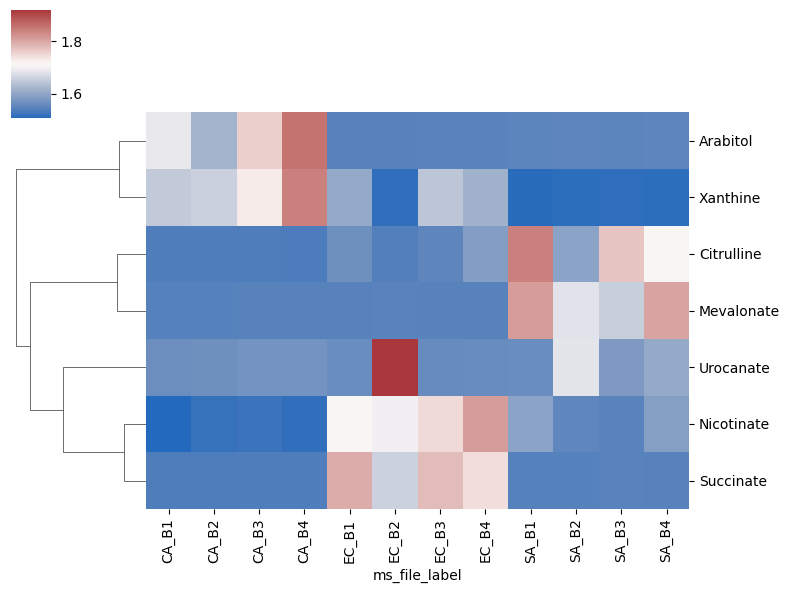

In [2]:
def zscore_rows(df: pd.DataFrame) -> pd.DataFrame:
    vals = df.to_numpy(dtype=float)
    mean = np.nanmean(vals, axis=1, keepdims=True)
    std = np.nanstd(vals, axis=1, ddof=0, keepdims=True)
    std = np.where(std == 0, np.nan, std)  # if row is constant, return NaN
    z = (vals - mean) / std
    return pd.DataFrame(z, index=df.index, columns=df.columns)

def rocke_durbin(df: pd.DataFrame, c: float) -> pd.DataFrame:
    # df: samples x features (metabolites)
    z = df.to_numpy(dtype=float)
    ef = np.log((z + np.sqrt(z**2 + c**2)) / 2.0)
    return pd.DataFrame(ef, index=df.index, columns=df.columns)

df_scaled = zscore_rows(df)
df_durbin = rocke_durbin(df_scaled, c=10)

sns.clustermap(df_durbin, method='ward', metric='euclidean', cmap='vlag', standard_scale=None, col_cluster=False, figsize=(8,6))

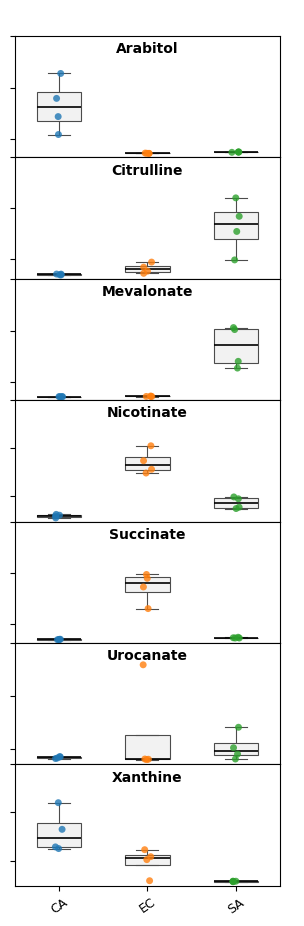

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_compound_panels_subplots(df_durbin: pd.DataFrame, sample_groups: pd.Series,
                                  compounds=None, palette="tab10"):
    """
    df_durbin: compounds (rows) x samples (cols)
    sample_groups: pd.Series indexed by sample names (matching df_durbin.columns), values = group labels
    compounds: optional list/sequence to choose which compounds to plot; defaults to all
    """
    if compounds is None:
        compounds = list(df_durbin.index)

    groups = sample_groups.loc[df_durbin.columns]
    order = list(pd.Index(groups.unique()))
    pal = sns.color_palette(palette, n_colors=len(order))

    # long form for convenience
    long_df = (
        df_durbin.loc[compounds]
        .T.join(groups.rename("group"))
        .melt(id_vars="group", var_name="compound", value_name="value")
    )

    n = len(compounds)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(3, 1.3 * n), sharex=True, gridspec_kw={"hspace": 0})
    if n == 1:
        axes = [axes]

    for ax, (comp, sub) in zip(axes, long_df.groupby("compound", sort=False)):
        sns.stripplot(
            data=sub, x="group", y="value",
            order=order, hue="group", palette=pal,
            jitter=0.05, dodge=False, size=5, linewidth=0, ax=ax, alpha=0.8,
        )
        sns.boxplot(
            data=sub, x="group", y="value",
            order=order, ax=ax, showfliers=False, width=0.5,
            boxprops={"facecolor": (0, 0, 0, 0.05), "linewidth": 0.8},
            whiskerprops={"linewidth": 0.8},
            capprops={"linewidth": 0.8},
            medianprops={"linewidth": 1.2, "color": "k"},
        )
        # ax.set_ylabel(comp, rotation=0, ha="right", va="center")
        ax.set_ylabel("")
        # ax.yaxis.set_label_coords(-0.03, 0.5)
        ax.set_xlabel("")
        # ax.grid(axis="y", color="0.85", linewidth=0.6)
        # sns.despine(ax=ax, left=True)
        # ax.legend_.remove()  # remove per-axis legend
        ax.tick_params(axis="y", labelleft=False)
        ax.set_ylim(top=2)
        ax.text(0.5, 0.95, comp, transform=ax.transAxes, fontsize=10, fontweight="bold", va="top", ha="center")

    axes[-1].tick_params(axis="x", rotation=35, labelsize=9)
    # single shared legend (optional)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, order, loc="upper right", bbox_to_anchor=(1.02, 1.02), frameon=False)
    plt.tight_layout()
    plt.show()


# Example usage:
sample_groups = pd.Series(dict(zip(df_durbin.columns, [c.split('_')[0] for c in df_durbin.columns])))
plot_compound_panels_subplots(df_durbin, sample_groups, compounds=df_durbin.index)

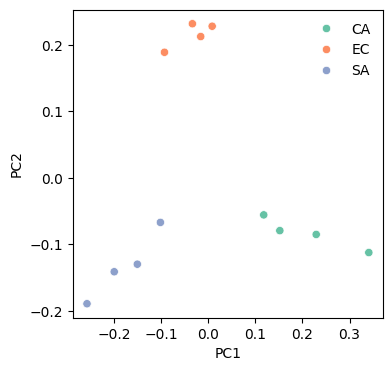

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def run_pca_samples_in_cols(df: pd.DataFrame, n_components=None, random_state=0):
    # df: features (rows) x samples (columns)
    X = df.to_numpy(dtype=float).T  # shape: samples x features

    pca = PCA(n_components=n_components, random_state=random_state)
    scores = pca.fit_transform(X)  # samples x components

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)

    loadings = pd.DataFrame(
        pca.components_.T,  # features x components
        index=df.index,
        columns=[f"PC{i+1}" for i in range(pca.n_components_)]
    )
    scores_df = pd.DataFrame(
        scores,
        index=df.columns,  # original columns = samples
        columns=[f"PC{i+1}" for i in range(pca.n_components_)]
    )

    return {
        "pca": pca,
        "scores": scores_df,
        "loadings": loadings,
        "explained_variance_ratio": pd.Series(explained, index=loadings.columns),
        "cumulative_variance_ratio": pd.Series(cumulative, index=loadings.columns),
    }


results = run_pca_samples_in_cols(df_durbin, n_components=5)

plt.figure(figsize=(4,4))
ax = sns.scatterplot(
    data=results["scores"],
    x="PC1",
    y="PC2",
    hue=[c.split('_')[0] for c in results['scores'].index],
    palette='Set2',
)

ax.legend(frameon=False)

Text(0, 0.5, 'Variance Explained')

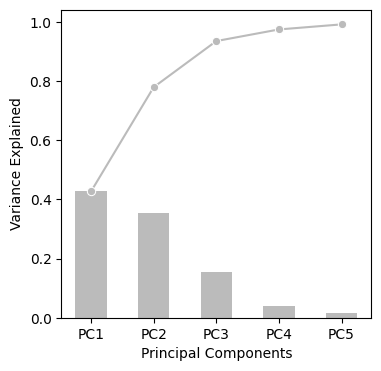

In [5]:
plt.figure(figsize=(4,4))

ax=sns.barplot(
    x=results['explained_variance_ratio'].index,
    y=results['explained_variance_ratio'].values,
    color='#bbbbbb', width=0.5
)
ax=sns.lineplot(
    x=results['cumulative_variance_ratio'].index,
    y=results['cumulative_variance_ratio'].values,
    marker='o', color='#bbbbbb'
)

ax.set_xlabel('Principal Components')
ax.set_ylabel('Variance Explained')

In [18]:
import numpy as np
import time

# Optional tqdm progress bar
try:
    from tqdm import tqdm
except ImportError:
    tqdm = None

from scipy.ndimage import binary_opening

def sparsify_chrom_fast(
    scan,
    intensity,
    w=1,
    baseline=1.0,
    eps=0.0,
    min_peak_width=3,
):
    scan = np.asarray(scan)
    intensity = np.asarray(intensity)

    signal = intensity > (baseline + eps)
    if not np.any(signal):
        return scan[:0], intensity[:0]

    # Remove small islands (shorter than min_peak_width)
    structure = np.ones(min_peak_width, dtype=bool)
    cleaned_signal = binary_opening(signal, structure=structure)
    if not np.any(cleaned_signal):
        return scan[:0], intensity[:0]

    kernel = np.ones(2 * w + 1, dtype=np.int8)
    keep = np.convolve(cleaned_signal.astype(np.int8), kernel, mode="same") > 0

    return scan[keep], intensity[keep]


# -----------------------------------------
# 2. Mock "real-ish" chromatograms (1200 points)
# -----------------------------------------

def generate_mock_chromatogram(
    n_scans=1200,
    n_peaks=15,
    baseline=1.0,
    noise_sigma=0.05,
    peak_min_width=5,
    peak_max_width=50,
    zero_dropout_prob=0.1,
    random_state=None,
):
    """
    Generate a toy chromatogram of length n_scans with:
      - baseline around 1.0
      - small Gaussian noise
      - multiple peaks with varying width
      - some true zeros
    """
    rng = np.random.default_rng(random_state)

    scan = np.arange(n_scans, dtype=int)

    # Baseline + noise
    intensity = np.full(n_scans, baseline, dtype=float)
    intensity += rng.normal(0, noise_sigma, size=n_scans)

    # Add peaks
    peak_centers = rng.integers(0, n_scans, size=n_peaks)
    peak_centers.sort()
    peak_widths = rng.integers(peak_min_width, peak_max_width + 1, size=n_peaks)

    for c, w in zip(peak_centers, peak_widths):
        idx = np.arange(n_scans)
        # Simple Gaussian peak
        peak = np.exp(-0.5 * ((idx - c) / w) ** 2)
        peak *= rng.uniform(50, 5000)  # peak height
        intensity += peak

    # Some true zeros (non-informative)
    dropout_mask = rng.random(n_scans) < zero_dropout_prob
    intensity[dropout_mask] = 0.0

    # Clip negatives just in case
    intensity[intensity < 0] = 0.0

    return scan, intensity


def generate_mock_batch(
    n_chrom=500,
    n_scans=1200,
    **kwargs,
):
    scans_list = []
    intensities_list = []
    rng = np.random.default_rng(0)

    for i in range(n_chrom):
        rs = rng.integers(0, 1_000_000)
        s, inten = generate_mock_chromatogram(
            n_scans=n_scans,
            random_state=rs,
            **kwargs,
        )
        scans_list.append(s)
        intensities_list.append(inten)

    return scans_list, intensities_list


# -----------------------------------------
# 3. Benchmark for 1200-point chromatograms
# -----------------------------------------

def benchmark_sparsify_new(
    n_chrom=500,
    n_scans=1200,
    w=1,
    baseline=1.0,
    eps=0.0,
    min_peak_width=3,
):
    print(f"Generating mock chromatograms: {n_chrom} × {n_scans} points")

    scans_list, intensities_list = generate_mock_batch(
        n_chrom=n_chrom,
        n_scans=n_scans,
        baseline=baseline,
        noise_sigma=0.25,
        n_peaks=15,
        peak_min_width=5,
        peak_max_width=60,
        zero_dropout_prob=0.1,
    )

    total_points_before = n_chrom * n_scans

    # Time ONLY the sparsification step
    if tqdm is not None:
        iterator = tqdm(range(n_chrom), desc="Sparsifying")
    else:
        iterator = range(n_chrom)

    t0 = time.perf_counter()
    kept_counts = []
    for i in iterator:
        s = scans_list[i]
        inten = intensities_list[i]
        s_kept, inten_kept = sparsify_chrom(
            s,
            inten,
            w=w,
            baseline=baseline,
            eps=eps,
            min_peak_width=min_peak_width,
        )
        kept_counts.append(len(s_kept))
    t1 = time.perf_counter()

    total_points_after = int(np.sum(kept_counts))
    frac_kept = total_points_after / total_points_before
    total_time = t1 - t0
    time_per_chrom = total_time / n_chrom

    print("\nBenchmark results")
    print("=================")
    print(f"Chromatograms:           {n_chrom}")
    print(f"Points per chromatogram: {n_scans}")
    print(f"Total points before:     {total_points_before:,}")
    print(f"Total points after:      {total_points_after:,}")
    print(f"Fraction kept:           {frac_kept:.3f}")
    print(f"Total sparsify time:     {total_time:.4f} s")
    print(f"Time per chromatogram:   {time_per_chrom:.6f} s")


if __name__ == "__main__":
    # Example: 500 chromatograms, 1200 points each
    benchmark_sparsify_new(
        n_chrom=100000,
        n_scans=1200,
        w=1,
        baseline=1.0,
        eps=0.05,       # ignore tiny bumps above baseline
        min_peak_width=3,
    )


Generating mock chromatograms: 100000 × 1200 points


Sparsifying: 100%|██████████| 100000/100000 [00:44<00:00, 2261.95it/s]


Benchmark results
Chromatograms:           100000
Points per chromatogram: 1200
Total points before:     120,000,000
Total points after:      113,220,145
Fraction kept:           0.944
Total sparsify time:     44.2099 s
Time per chromatogram:   0.000442 s
